<h1> 챕터4 : word2vec 속도 개선 </h1>

<p> 
    챕터3 장에서 word2vec의 구조를 배우고 CBOW 모델을 구현하였다. 하지만 몇 가지 문제가 있는데, 가장 큰 문제는 말뭉치에 포함된 어휘 수가 많아지면 계산량도 커진다는 점이다.
    이번 챕터에서는 이 문제를 잡기 위한 두 가지 개선을 추가한다. 첫 번째는 Embedding 이라는 새로운 레이어를 추가하는 것과 두 번째는 네거티브 샘플링이라는 손실 함수를 도입하는 것 이다. 
    
</p>


<h2> 4.1 word2vec 개선 1 </h2>

<p>
    CBOW 모델은 단어 2개를 맥락으로 사용하여, 하나의 단어(target)을 추측한다. 입력 측 가중치($ W_{in}$) 와의 행렬 곱으로 은닉층이 계산되고, 출력 층 가중치($W_{out}$) 와의 행렬 곱으로 각 단어의 점수를 구한다. 이 점수를 소프트맥스 함수를 적용해 단어의 출현 확률을 얻고, 정답 레이블과 비교하여 손실을 구한다. 
</p>
<p>
    거대한 말뭉치를 다루게 되면 몇 가지 문제가 발생한다. 만약 어휘가 100만 개, 은닉층 뉴련 100개인 CBOW 모델을 있다고 가정하겠다. 입력층과 출력층에는 각 100만개의 뉴런이 존재한다. 수많은 뉴런 때문에 중간 계산에 많은 시간이 소요된다. 두 계산이 병목 된다.
    <ol>
        <li>입력층의 원핫 표현과 가중치 행렬 $W_{in}$의 곱 계산</li>
        <li>은닉층과 가중치 행렬 $W_{out}$의 곱 및 Softmax 계층의 계산</li>
    </ol>
    첫 번째는 입력층의 원핫 표현과 관련 되었다. 단어를 원핫 표현하기 때문에 어휘 수가 많아지면 벡터 크기가 커진다. 어휘가 100만 개라면 원소 수가 100만 개인 벡터가 된다. 이 원핫 벡터와 가중치 행렬 $\textbf{W_{in}}$을 곱하는데 계산 자원을 상당히 사용한다, 이 문제는 Embedding 계층을 도입하는 것으로 해결한다.
</p>

<p>
    은닉층과 가중치 행렬 $\textbf{W_{out}}$ 의 곱을 하면 계산량이 상당하다. Softmax 계층에서도 다루는 어휘가 많아짐에 따라 계산량이 증가하는 문제가 있다. 이 문제는 네거티브 샘플링으로 해결된다.
</p>

<h3> 4.1.1 Embedding 계층 </h3>

<p>
    전처리시 단어를 원핫 표현으로 바꾸었다. 이제는 가중치 매개변수로부터 '단어 ID에 해당하는 행(벡터)'을 추출하는 계층을 만든다. 그 계층이 Embedding 계층이다. Embedding 은 단어 임베딩이라는 용어에서 유래했다. 
</p>

<h3> 4.1.2 Embedding 계층 구현 </h3>

In [1]:
import numpy as np
W = np.arange(21).reshape(7,3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [2]:
W[2]

array([6, 7, 8])

In [3]:
W[5]

array([15, 16, 17])

In [4]:
idx = np.array([1, 0, 3, 0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [7]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dw[...] = 0
        
        for i, word_id in enumerate(self.idx):
            dW[word_id] += dout[i]
        
        # Or
        # np.add.at(dW. self.idx, dout)
        
        return None

 <p>
   Embedding 계층의 순전파는 가중치 W의 특정 행을 추출할 뿐이다. 역전파는 앞 층으로부터 전해진 기울기를 다음 층으로 그래로 흘려 주면 된다. 다만, 앞 층으로부터 전해진 기울기를 가중치 기울기 dW의 특정 행에 설정한다.
</p>
<p>
    idx의 원소가 중복될 때 dW의 값이 2개 이상 할당 될 수 있다 이 때 중복 문제를 해결하려면 '할당'이 아닌 '더하기;를 해야 한다. 
</p>

<h2> 4.2 word2vec 개선 2 </h2>

<p>
    남은 병목은 은닉층 이후의 처리이다. 네거티브 샘플링을 활용하면 해결할 수 있다. 네거티브 샘플링을 이용하면 어휘가 많아져도 계산량을 낮은 수준에서 일정하게 억제할 수 있다.
</p>

<h3> 4.2.1 은닉층 이후 계산의 문제점 </h3>

<p>
    은닉층 이후에서 계산이 오래 걸리는 곳은 두 부분이다.
    <ol>
        <li> 은닉층의 뉴런과 가중치 행렬($W_{out}$)의 곱</li>
        <li> Softmax 계층의 계산 </li>
    </ol>
    첫 번째는 거대한 행렬을 곱하는 문제이다. 은닉층의 벡터 크기가 100이고, 가중치 행렬의 크기가 100 X 100만이다. 큰 행렬의 곱을 계산하려면 시간이 오래걸린다. 역전파에서도 같은 계산을 수행하기 때문에 행렬 곱을 <mark>가볍게</mark> 만들어야 한다.
</p>
<p>
    두 번째로, 어휘가 많아지면 Softmax의 계산량도 증가한다. 
</p>

<h3> 4.2.2 다중 분류에서 이진 분류로 </h3>

<p>
    네거티브 샘플링의 핵심 아이디어는 '이진 분류' 이다. 더 정확히 말하면, '다중 분류'를 '이진 분류'로 근사하는 것이 네거티브 샘플링을 이해하는 중요한 포인트 이다. 이진 분류 방식으로 해결할려면, 문제의 답을 "yes/no"로 답할 수 있는 문제로 바꾸어야 한다. ""you"와 "goodbye"를 입력하면 무슨 단어가 나옵니까?"의 문제를 ""you"와 "goodbye"를 입력하면 "say"라는 단어가 나옵니까?" 로 바꾸는 것이다. 
</p>

<h3> 4.2.3 시그모이드 함수와 교차 엔트로피 오차 </h3>

<p>
    이진 분류 문제를 신경망으로 풀려면 점수에 시그모이드 함수를 적용해 확률로 변환해야 한다. 손실을 구할 때는 손실 함수로 '교차 엔트로피 오차'를 사용한다. 
</p>

<h3> 4.2.4 다중 분류에서 이진 분류 (구현) </h3>

<p>
    신경망을 이진 분류 신경망으로 변환하면, 은닉층 뉴런 <b>h</b>와, 출력 측 가중치 <b>$W_{out}$</b> (정답 say의 원핫 벡터를 임베딩하여 나온 벡터)에 해당하는 단어 벡터와의 내적을 계산한다. 그리고 Sigmoid with Loss 계층에 입력해 최종 손실을 얻는다. 이를 위해 Embedding Dot 계층을 도입한다. 
     
</p>

In [1]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
        
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)
        
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        
        dout = dout.reshape(dout.shape[0], 1)
        
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

<p>
    EmbeddingDot 클래스는 총 4개의 인스턴스 변수가 있다. embed는 Embedding 계층, cache는 순전파 시의 계산 결과를 잠시 유지를 위한 변수로 사용한다. 이후, backward에서 간단히 꺼내서 사용할 수 있다. forward 메서드는 인수로 은닉층 뉴런(h)과 단어 ID의 넘파이 배열(idx)를 받는다. idx가 배열인 이유는 미니배치를 고려해서다. 
</p>

<h3> 4.2.5 네거티브 샘플링 </h3>

<p>
    지금까지 긍정적인 예(정답)에 대해서만 학습하였다. 부정적인 예에 대해서도 학습을 해야 한다. 정답에는 Sigmoid 확률을 1로 높이고 오답에는 Sigmoid 계층 학률을 0으로 학습시켜야 된다. 하지만 모든 부정적 예를 대상으로 이진 분류를 학습하기에는 어휘 수가 늘어나면 감당할 수가 없다. 즉, 근사적으로 부정적 예를 샘플링 해서 사용해야 한다. 이것이 네거티브 샘플링(negative sampling) 이다. 
</p>

<h3> 4.2.6 네거티브 샘플링의 샘플링 기법 </h3>

<p>
    부정적 예를 어떻게 샘플링하는 방법이 남아있다. 단순 무작위보다 말뭉치의 통계 데이터를 이용하여 샘플링하는 것이 좋다. 자주 등장하는 단어를 많이 추출하고 드물게 등장하는 단어는 적게 추출하는 방식이다. 단어의 출현 횟수를 구해서 확률분포를 구하여 단어를 샘플링하면 된다. 
</p>

In [1]:
import numpy as np

In [2]:
np.random.choice(10)

9

In [3]:
np.random.choice(10)

2

In [4]:
words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
np.random.choice(words)

'you'

In [5]:
np.random.choice(words, size=5)

array(['.', 'you', 'you', 'goodbye', 'say'], dtype='<U7')

In [6]:
np.random.choice(words, size=5, replace=False)

array(['hello', 'you', 'I', 'goodbye', 'say'], dtype='<U7')

In [7]:
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice(words, p=p)

'you'

<p>
    word2vec의 네거티브 샘플링에서 앞의 확률분포에서 한 가지를 수정해야한다. 기본 확률분포에 0.75를 제곱하는 것이다.
    $$
        P^{'}(W_i) ={ P(W_i)^{0.75} \over \sum_j^n{P(W_j)^{0.75}}}
    $$
    여기서 $P(w_i)$는 i번째 단어의 확률이다. 0.75 를 제곱하는 수정을 하는 이유는 출현 확률이 낮은 단어가 조금 더 자주 출현하기 위함이다. 원래 확률이 낮은 단어의 확률을 살짝 높일 수 있다. 
</p>

In [9]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


In [12]:
from negative_sampling_layer import UnigramSampler

corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[4 3]
 [0 2]
 [1 4]]


<h3> 4.2.7 네거티브 샘플링 구현 </h3>

In [14]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)
            
        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
            
        return dh

<h2> 4.3 개선판 word2vec 학습 </h2>

<h3> 4.3.1 CBOW 모델 구현 </h3>

In [16]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import Embedding
from ch04.negative_sampling_layer import NegativeSamplingLoss

class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in) # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params 
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

<h3> 4.3.2 CBOW 모델 학습 코드 </h3>

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 1[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 2[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 3[s] | 손실 4.05
| 에폭 1 |  반복 101 / 9295 | 시간 4[s] | 손실 3.92
| 에폭 1 |  반복 121 / 9295 | 시간 5[s] | 손실 3.78
| 에폭 1 |  반복 141 / 9295 | 시간 5[s] | 손실 3.63
| 에폭 1 |  반복 161 / 9295 | 시간 6[s] | 손실 3.48
| 에폭 1 |  반복 181 / 9295 | 시간 7[s] | 손실 3.36
| 에폭 1 |  반복 201 / 9295 | 시간 8[s] | 손실 3.26
| 에폭 1 |  반복 221 / 9295 | 시간 9[s] | 손실 3.16
| 에폭 1 |  반복 241 / 9295 | 시간 10[s] | 손실 3.08
| 에폭 1 |  반복 261 / 9295 | 시간 10[s] | 손실 3.00
| 에폭 1 |  반복 281 / 9295 | 시간 11[s] | 손실 2.98
| 에폭 1 |  반복 301 / 9295 | 시간 12[s] | 손실 2.90
| 에폭 1 |  반복 321 / 9295 | 시간 13[s] | 손실 2.88
| 에폭 1 |  반복 341 / 9295 | 시간 14[s] | 손실 2.85
| 에폭 1 |  반복 361 / 9295 | 시간 15[s] | 손실 2.81
| 에폭 1 |  반복 381 / 9295 | 시간 16[s] | 손실 2.79
| 에폭 1 |  반복 401 / 9295 | 시간 16[s] | 손실 2.75
| 에폭 1 |  반복 421 / 9295 | 시간 17[s] | 손실 2.76
| 에폭 1 |  반복 441 / 9295 | 시간

| 에폭 1 |  반복 3581 / 9295 | 시간 150[s] | 손실 2.42
| 에폭 1 |  반복 3601 / 9295 | 시간 151[s] | 손실 2.43
| 에폭 1 |  반복 3621 / 9295 | 시간 152[s] | 손실 2.43
| 에폭 1 |  반복 3641 / 9295 | 시간 153[s] | 손실 2.43
| 에폭 1 |  반복 3661 / 9295 | 시간 154[s] | 손실 2.41
| 에폭 1 |  반복 3681 / 9295 | 시간 154[s] | 손실 2.42
| 에폭 1 |  반복 3701 / 9295 | 시간 155[s] | 손실 2.39
| 에폭 1 |  반복 3721 / 9295 | 시간 156[s] | 손실 2.42
| 에폭 1 |  반복 3741 / 9295 | 시간 157[s] | 손실 2.41
| 에폭 1 |  반복 3761 / 9295 | 시간 158[s] | 손실 2.41
| 에폭 1 |  반복 3781 / 9295 | 시간 159[s] | 손실 2.40
| 에폭 1 |  반복 3801 / 9295 | 시간 159[s] | 손실 2.43
| 에폭 1 |  반복 3821 / 9295 | 시간 160[s] | 손실 2.39
| 에폭 1 |  반복 3841 / 9295 | 시간 161[s] | 손실 2.39
| 에폭 1 |  반복 3861 / 9295 | 시간 162[s] | 손실 2.45
| 에폭 1 |  반복 3881 / 9295 | 시간 163[s] | 손실 2.43
| 에폭 1 |  반복 3901 / 9295 | 시간 164[s] | 손실 2.38
| 에폭 1 |  반복 3921 / 9295 | 시간 165[s] | 손실 2.41
| 에폭 1 |  반복 3941 / 9295 | 시간 165[s] | 손실 2.42
| 에폭 1 |  반복 3961 / 9295 | 시간 166[s] | 손실 2.40
| 에폭 1 |  반복 3981 / 9295 | 시간 167[s] | 손실 2.41
| 에폭 1 |  반복 

| 에폭 1 |  반복 7081 / 9295 | 시간 298[s] | 손실 2.29
| 에폭 1 |  반복 7101 / 9295 | 시간 299[s] | 손실 2.29
| 에폭 1 |  반복 7121 / 9295 | 시간 299[s] | 손실 2.29
| 에폭 1 |  반복 7141 / 9295 | 시간 300[s] | 손실 2.32
| 에폭 1 |  반복 7161 / 9295 | 시간 301[s] | 손실 2.28
| 에폭 1 |  반복 7181 / 9295 | 시간 302[s] | 손실 2.27
| 에폭 1 |  반복 7201 / 9295 | 시간 303[s] | 손실 2.26
| 에폭 1 |  반복 7221 / 9295 | 시간 304[s] | 손실 2.29
| 에폭 1 |  반복 7241 / 9295 | 시간 304[s] | 손실 2.27
| 에폭 1 |  반복 7261 / 9295 | 시간 305[s] | 손실 2.30
| 에폭 1 |  반복 7281 / 9295 | 시간 306[s] | 손실 2.29
| 에폭 1 |  반복 7301 / 9295 | 시간 307[s] | 손실 2.29
| 에폭 1 |  반복 7321 / 9295 | 시간 308[s] | 손실 2.29
| 에폭 1 |  반복 7341 / 9295 | 시간 309[s] | 손실 2.25
| 에폭 1 |  반복 7361 / 9295 | 시간 310[s] | 손실 2.27
| 에폭 1 |  반복 7381 / 9295 | 시간 310[s] | 손실 2.26
| 에폭 1 |  반복 7401 / 9295 | 시간 311[s] | 손실 2.25
| 에폭 1 |  반복 7421 / 9295 | 시간 312[s] | 손실 2.29
| 에폭 1 |  반복 7441 / 9295 | 시간 313[s] | 손실 2.24
| 에폭 1 |  반복 7461 / 9295 | 시간 314[s] | 손실 2.26
| 에폭 1 |  반복 7481 / 9295 | 시간 315[s] | 손실 2.31
| 에폭 1 |  반복 

| 에폭 2 |  반복 1301 / 9295 | 시간 446[s] | 손실 2.16
| 에폭 2 |  반복 1321 / 9295 | 시간 447[s] | 손실 2.17
| 에폭 2 |  반복 1341 / 9295 | 시간 448[s] | 손실 2.17
| 에폭 2 |  반복 1361 / 9295 | 시간 449[s] | 손실 2.17
| 에폭 2 |  반복 1381 / 9295 | 시간 450[s] | 손실 2.14
| 에폭 2 |  반복 1401 / 9295 | 시간 450[s] | 손실 2.14
| 에폭 2 |  반복 1421 / 9295 | 시간 451[s] | 손실 2.15
| 에폭 2 |  반복 1441 / 9295 | 시간 452[s] | 손실 2.15
| 에폭 2 |  반복 1461 / 9295 | 시간 453[s] | 손실 2.11
| 에폭 2 |  반복 1481 / 9295 | 시간 454[s] | 손실 2.15
| 에폭 2 |  반복 1501 / 9295 | 시간 455[s] | 손실 2.13
| 에폭 2 |  반복 1521 / 9295 | 시간 456[s] | 손실 2.15
| 에폭 2 |  반복 1541 / 9295 | 시간 456[s] | 손실 2.14
| 에폭 2 |  반복 1561 / 9295 | 시간 457[s] | 손실 2.15
| 에폭 2 |  반복 1581 / 9295 | 시간 458[s] | 손실 2.17
| 에폭 2 |  반복 1601 / 9295 | 시간 459[s] | 손실 2.17
| 에폭 2 |  반복 1621 / 9295 | 시간 460[s] | 손실 2.13
| 에폭 2 |  반복 1641 / 9295 | 시간 461[s] | 손실 2.11
| 에폭 2 |  반복 1661 / 9295 | 시간 461[s] | 손실 2.16
| 에폭 2 |  반복 1681 / 9295 | 시간 462[s] | 손실 2.12
| 에폭 2 |  반복 1701 / 9295 | 시간 463[s] | 손실 2.12
| 에폭 2 |  반복 

| 에폭 2 |  반복 4801 / 9295 | 시간 594[s] | 손실 2.08
| 에폭 2 |  반복 4821 / 9295 | 시간 595[s] | 손실 2.05
| 에폭 2 |  반복 4841 / 9295 | 시간 596[s] | 손실 2.12
| 에폭 2 |  반복 4861 / 9295 | 시간 596[s] | 손실 2.09
| 에폭 2 |  반복 4881 / 9295 | 시간 597[s] | 손실 2.09
| 에폭 2 |  반복 4901 / 9295 | 시간 598[s] | 손실 2.08
| 에폭 2 |  반복 4921 / 9295 | 시간 599[s] | 손실 2.06
| 에폭 2 |  반복 4941 / 9295 | 시간 600[s] | 손실 2.09
| 에폭 2 |  반복 4961 / 9295 | 시간 601[s] | 손실 2.07
| 에폭 2 |  반복 4981 / 9295 | 시간 602[s] | 손실 2.12
| 에폭 2 |  반복 5001 / 9295 | 시간 602[s] | 손실 2.10
| 에폭 2 |  반복 5021 / 9295 | 시간 603[s] | 손실 2.06
| 에폭 2 |  반복 5041 / 9295 | 시간 604[s] | 손실 2.06
| 에폭 2 |  반복 5061 / 9295 | 시간 605[s] | 손실 2.08
| 에폭 2 |  반복 5081 / 9295 | 시간 606[s] | 손실 2.09
| 에폭 2 |  반복 5101 / 9295 | 시간 607[s] | 손실 2.08
| 에폭 2 |  반복 5121 / 9295 | 시간 607[s] | 손실 2.05
| 에폭 2 |  반복 5141 / 9295 | 시간 608[s] | 손실 2.10
| 에폭 2 |  반복 5161 / 9295 | 시간 609[s] | 손실 2.05
| 에폭 2 |  반복 5181 / 9295 | 시간 610[s] | 손실 2.07
| 에폭 2 |  반복 5201 / 9295 | 시간 611[s] | 손실 2.07
| 에폭 2 |  반복 

| 에폭 2 |  반복 8301 / 9295 | 시간 741[s] | 손실 2.05
| 에폭 2 |  반복 8321 / 9295 | 시간 742[s] | 손실 2.03
| 에폭 2 |  반복 8341 / 9295 | 시간 743[s] | 손실 2.01
| 에폭 2 |  반복 8361 / 9295 | 시간 744[s] | 손실 2.00
| 에폭 2 |  반복 8381 / 9295 | 시간 745[s] | 손실 2.06
| 에폭 2 |  반복 8401 / 9295 | 시간 745[s] | 손실 2.03
| 에폭 2 |  반복 8421 / 9295 | 시간 746[s] | 손실 2.02
| 에폭 2 |  반복 8441 / 9295 | 시간 747[s] | 손실 2.06
| 에폭 2 |  반복 8461 / 9295 | 시간 748[s] | 손실 2.07
| 에폭 2 |  반복 8481 / 9295 | 시간 749[s] | 손실 2.01
| 에폭 2 |  반복 8501 / 9295 | 시간 750[s] | 손실 2.07
| 에폭 2 |  반복 8521 / 9295 | 시간 751[s] | 손실 2.03
| 에폭 2 |  반복 8541 / 9295 | 시간 751[s] | 손실 2.03
| 에폭 2 |  반복 8561 / 9295 | 시간 752[s] | 손실 2.05
| 에폭 2 |  반복 8581 / 9295 | 시간 753[s] | 손실 2.03
| 에폭 2 |  반복 8601 / 9295 | 시간 754[s] | 손실 2.03
| 에폭 2 |  반복 8621 / 9295 | 시간 755[s] | 손실 2.05
| 에폭 2 |  반복 8641 / 9295 | 시간 756[s] | 손실 1.97
| 에폭 2 |  반복 8661 / 9295 | 시간 756[s] | 손실 2.05
| 에폭 2 |  반복 8681 / 9295 | 시간 757[s] | 손실 2.03
| 에폭 2 |  반복 8701 / 9295 | 시간 758[s] | 손실 2.05
| 에폭 2 |  반복 

| 에폭 3 |  반복 2521 / 9295 | 시간 906[s] | 손실 1.92
| 에폭 3 |  반복 2541 / 9295 | 시간 907[s] | 손실 1.95
| 에폭 3 |  반복 2561 / 9295 | 시간 908[s] | 손실 1.95
| 에폭 3 |  반복 2581 / 9295 | 시간 909[s] | 손실 1.95
| 에폭 3 |  반복 2601 / 9295 | 시간 910[s] | 손실 1.94
| 에폭 3 |  반복 2621 / 9295 | 시간 911[s] | 손실 1.97
| 에폭 3 |  반복 2641 / 9295 | 시간 912[s] | 손실 1.91
| 에폭 3 |  반복 2661 / 9295 | 시간 913[s] | 손실 1.91
| 에폭 3 |  반복 2681 / 9295 | 시간 913[s] | 손실 1.92
| 에폭 3 |  반복 2701 / 9295 | 시간 914[s] | 손실 1.87
| 에폭 3 |  반복 2721 / 9295 | 시간 915[s] | 손실 1.89
| 에폭 3 |  반복 2741 / 9295 | 시간 916[s] | 손실 1.95
| 에폭 3 |  반복 2761 / 9295 | 시간 917[s] | 손실 1.93
| 에폭 3 |  반복 2781 / 9295 | 시간 918[s] | 손실 1.93
| 에폭 3 |  반복 2801 / 9295 | 시간 919[s] | 손실 1.93
| 에폭 3 |  반복 2821 / 9295 | 시간 920[s] | 손실 1.98
| 에폭 3 |  반복 2841 / 9295 | 시간 921[s] | 손실 1.94
| 에폭 3 |  반복 2861 / 9295 | 시간 921[s] | 손실 1.95
| 에폭 3 |  반복 2881 / 9295 | 시간 922[s] | 손실 1.89
| 에폭 3 |  반복 2901 / 9295 | 시간 923[s] | 손실 1.95
| 에폭 3 |  반복 2921 / 9295 | 시간 924[s] | 손실 1.95
| 에폭 3 |  반복 

| 에폭 3 |  반복 5981 / 9295 | 시간 1061[s] | 손실 1.92
| 에폭 3 |  반복 6001 / 9295 | 시간 1062[s] | 손실 1.86
| 에폭 3 |  반복 6021 / 9295 | 시간 1062[s] | 손실 1.92
| 에폭 3 |  반복 6041 / 9295 | 시간 1063[s] | 손실 1.91
| 에폭 3 |  반복 6061 / 9295 | 시간 1064[s] | 손실 1.91
| 에폭 3 |  반복 6081 / 9295 | 시간 1065[s] | 손실 1.91
| 에폭 3 |  반복 6101 / 9295 | 시간 1066[s] | 손실 1.92
| 에폭 3 |  반복 6121 / 9295 | 시간 1067[s] | 손실 1.93
| 에폭 3 |  반복 6141 / 9295 | 시간 1067[s] | 손실 1.89
| 에폭 3 |  반복 6161 / 9295 | 시간 1068[s] | 손실 1.91
| 에폭 3 |  반복 6181 / 9295 | 시간 1069[s] | 손실 1.91
| 에폭 3 |  반복 6201 / 9295 | 시간 1070[s] | 손실 1.90
| 에폭 3 |  반복 6221 / 9295 | 시간 1071[s] | 손실 1.95
| 에폭 3 |  반복 6241 / 9295 | 시간 1071[s] | 손실 1.89
| 에폭 3 |  반복 6261 / 9295 | 시간 1072[s] | 손실 1.91
| 에폭 3 |  반복 6281 / 9295 | 시간 1073[s] | 손실 1.90
| 에폭 3 |  반복 6301 / 9295 | 시간 1074[s] | 손실 1.90
| 에폭 3 |  반복 6321 / 9295 | 시간 1075[s] | 손실 1.91
| 에폭 3 |  반복 6341 / 9295 | 시간 1075[s] | 손실 1.89
| 에폭 3 |  반복 6361 / 9295 | 시간 1076[s] | 손실 1.91
| 에폭 3 |  반복 6381 / 9295 | 시간 1077[s] | 

| 에폭 4 |  반복 101 / 9295 | 시간 1202[s] | 손실 1.81
| 에폭 4 |  반복 121 / 9295 | 시간 1203[s] | 손실 1.82
| 에폭 4 |  반복 141 / 9295 | 시간 1203[s] | 손실 1.82
| 에폭 4 |  반복 161 / 9295 | 시간 1204[s] | 손실 1.82
| 에폭 4 |  반복 181 / 9295 | 시간 1205[s] | 손실 1.78
| 에폭 4 |  반복 201 / 9295 | 시간 1206[s] | 손실 1.81
| 에폭 4 |  반복 221 / 9295 | 시간 1207[s] | 손실 1.83
| 에폭 4 |  반복 241 / 9295 | 시간 1208[s] | 손실 1.82
| 에폭 4 |  반복 261 / 9295 | 시간 1209[s] | 손실 1.78
| 에폭 4 |  반복 281 / 9295 | 시간 1209[s] | 손실 1.87
| 에폭 4 |  반복 301 / 9295 | 시간 1210[s] | 손실 1.83
| 에폭 4 |  반복 321 / 9295 | 시간 1211[s] | 손실 1.81
| 에폭 4 |  반복 341 / 9295 | 시간 1212[s] | 손실 1.81
| 에폭 4 |  반복 361 / 9295 | 시간 1213[s] | 손실 1.82
| 에폭 4 |  반복 381 / 9295 | 시간 1214[s] | 손실 1.81
| 에폭 4 |  반복 401 / 9295 | 시간 1215[s] | 손실 1.85
| 에폭 4 |  반복 421 / 9295 | 시간 1215[s] | 손실 1.81
| 에폭 4 |  반복 441 / 9295 | 시간 1216[s] | 손실 1.82
| 에폭 4 |  반복 461 / 9295 | 시간 1217[s] | 손실 1.81
| 에폭 4 |  반복 481 / 9295 | 시간 1218[s] | 손실 1.82
| 에폭 4 |  반복 501 / 9295 | 시간 1219[s] | 손실 1.81
| 에폭 4 |  반복 

| 에폭 4 |  반복 3541 / 9295 | 시간 1346[s] | 손실 1.85
| 에폭 4 |  반복 3561 / 9295 | 시간 1347[s] | 손실 1.81
| 에폭 4 |  반복 3581 / 9295 | 시간 1348[s] | 손실 1.79
| 에폭 4 |  반복 3601 / 9295 | 시간 1349[s] | 손실 1.85
| 에폭 4 |  반복 3621 / 9295 | 시간 1350[s] | 손실 1.80
| 에폭 4 |  반복 3641 / 9295 | 시간 1351[s] | 손실 1.83
| 에폭 4 |  반복 3661 / 9295 | 시간 1351[s] | 손실 1.78
| 에폭 4 |  반복 3681 / 9295 | 시간 1352[s] | 손실 1.81
| 에폭 4 |  반복 3701 / 9295 | 시간 1353[s] | 손실 1.82
| 에폭 4 |  반복 3721 / 9295 | 시간 1354[s] | 손실 1.83
| 에폭 4 |  반복 3741 / 9295 | 시간 1355[s] | 손실 1.81
| 에폭 4 |  반복 3761 / 9295 | 시간 1356[s] | 손실 1.83
| 에폭 4 |  반복 3781 / 9295 | 시간 1357[s] | 손실 1.84
| 에폭 4 |  반복 3801 / 9295 | 시간 1357[s] | 손실 1.78
| 에폭 4 |  반복 3821 / 9295 | 시간 1358[s] | 손실 1.83
| 에폭 4 |  반복 3841 / 9295 | 시간 1359[s] | 손실 1.81
| 에폭 4 |  반복 3861 / 9295 | 시간 1360[s] | 손실 1.83
| 에폭 4 |  반복 3881 / 9295 | 시간 1361[s] | 손실 1.86
| 에폭 4 |  반복 3901 / 9295 | 시간 1362[s] | 손실 1.84
| 에폭 4 |  반복 3921 / 9295 | 시간 1362[s] | 손실 1.85
| 에폭 4 |  반복 3941 / 9295 | 시간 1363[s] | 

| 에폭 4 |  반복 6961 / 9295 | 시간 1491[s] | 손실 1.78
| 에폭 4 |  반복 6981 / 9295 | 시간 1492[s] | 손실 1.81
| 에폭 4 |  반복 7001 / 9295 | 시간 1493[s] | 손실 1.80
| 에폭 4 |  반복 7021 / 9295 | 시간 1494[s] | 손실 1.84
| 에폭 4 |  반복 7041 / 9295 | 시간 1495[s] | 손실 1.77
| 에폭 4 |  반복 7061 / 9295 | 시간 1496[s] | 손실 1.81
| 에폭 4 |  반복 7081 / 9295 | 시간 1496[s] | 손실 1.83
| 에폭 4 |  반복 7101 / 9295 | 시간 1497[s] | 손실 1.84
| 에폭 4 |  반복 7121 / 9295 | 시간 1498[s] | 손실 1.82
| 에폭 4 |  반복 7141 / 9295 | 시간 1499[s] | 손실 1.81
| 에폭 4 |  반복 7161 / 9295 | 시간 1500[s] | 손실 1.79
| 에폭 4 |  반복 7181 / 9295 | 시간 1501[s] | 손실 1.83
| 에폭 4 |  반복 7201 / 9295 | 시간 1501[s] | 손실 1.84
| 에폭 4 |  반복 7221 / 9295 | 시간 1502[s] | 손실 1.82
| 에폭 4 |  반복 7241 / 9295 | 시간 1503[s] | 손실 1.81
| 에폭 4 |  반복 7261 / 9295 | 시간 1504[s] | 손실 1.83
| 에폭 4 |  반복 7281 / 9295 | 시간 1505[s] | 손실 1.80
| 에폭 4 |  반복 7301 / 9295 | 시간 1506[s] | 손실 1.83
| 에폭 4 |  반복 7321 / 9295 | 시간 1506[s] | 손실 1.78
| 에폭 4 |  반복 7341 / 9295 | 시간 1507[s] | 손실 1.79
| 에폭 4 |  반복 7361 / 9295 | 시간 1508[s] | 

| 에폭 5 |  반복 1101 / 9295 | 시간 1636[s] | 손실 1.72
| 에폭 5 |  반복 1121 / 9295 | 시간 1637[s] | 손실 1.73
| 에폭 5 |  반복 1141 / 9295 | 시간 1638[s] | 손실 1.75
| 에폭 5 |  반복 1161 / 9295 | 시간 1638[s] | 손실 1.71
| 에폭 5 |  반복 1181 / 9295 | 시간 1639[s] | 손실 1.74
| 에폭 5 |  반복 1201 / 9295 | 시간 1640[s] | 손실 1.71
| 에폭 5 |  반복 1221 / 9295 | 시간 1641[s] | 손실 1.73
| 에폭 5 |  반복 1241 / 9295 | 시간 1642[s] | 손실 1.73
| 에폭 5 |  반복 1261 / 9295 | 시간 1643[s] | 손실 1.73
| 에폭 5 |  반복 1281 / 9295 | 시간 1643[s] | 손실 1.70
| 에폭 5 |  반복 1301 / 9295 | 시간 1644[s] | 손실 1.67
| 에폭 5 |  반복 1321 / 9295 | 시간 1645[s] | 손실 1.74
| 에폭 5 |  반복 1341 / 9295 | 시간 1646[s] | 손실 1.74
| 에폭 5 |  반복 1361 / 9295 | 시간 1647[s] | 손실 1.78
| 에폭 5 |  반복 1381 / 9295 | 시간 1648[s] | 손실 1.75
| 에폭 5 |  반복 1401 / 9295 | 시간 1648[s] | 손실 1.71
| 에폭 5 |  반복 1421 / 9295 | 시간 1649[s] | 손실 1.72
| 에폭 5 |  반복 1441 / 9295 | 시간 1650[s] | 손실 1.76
| 에폭 5 |  반복 1461 / 9295 | 시간 1651[s] | 손실 1.72
| 에폭 5 |  반복 1481 / 9295 | 시간 1652[s] | 손실 1.74
| 에폭 5 |  반복 1501 / 9295 | 시간 1653[s] | 

| 에폭 5 |  반복 4521 / 9295 | 시간 1780[s] | 손실 1.74
| 에폭 5 |  반복 4541 / 9295 | 시간 1781[s] | 손실 1.73
| 에폭 5 |  반복 4561 / 9295 | 시간 1782[s] | 손실 1.67
| 에폭 5 |  반복 4581 / 9295 | 시간 1783[s] | 손실 1.70
| 에폭 5 |  반복 4601 / 9295 | 시간 1784[s] | 손실 1.72
| 에폭 5 |  반복 4621 / 9295 | 시간 1784[s] | 손실 1.73
| 에폭 5 |  반복 4641 / 9295 | 시간 1785[s] | 손실 1.77
| 에폭 5 |  반복 4661 / 9295 | 시간 1786[s] | 손실 1.71
| 에폭 5 |  반복 4681 / 9295 | 시간 1787[s] | 손실 1.70
| 에폭 5 |  반복 4701 / 9295 | 시간 1788[s] | 손실 1.72
| 에폭 5 |  반복 4721 / 9295 | 시간 1789[s] | 손실 1.72
| 에폭 5 |  반복 4741 / 9295 | 시간 1790[s] | 손실 1.72
| 에폭 5 |  반복 4761 / 9295 | 시간 1790[s] | 손실 1.72
| 에폭 5 |  반복 4781 / 9295 | 시간 1791[s] | 손실 1.75
| 에폭 5 |  반복 4801 / 9295 | 시간 1792[s] | 손실 1.71
| 에폭 5 |  반복 4821 / 9295 | 시간 1793[s] | 손실 1.66
| 에폭 5 |  반복 4841 / 9295 | 시간 1794[s] | 손실 1.73
| 에폭 5 |  반복 4861 / 9295 | 시간 1795[s] | 손실 1.70
| 에폭 5 |  반복 4881 / 9295 | 시간 1796[s] | 손실 1.76
| 에폭 5 |  반복 4901 / 9295 | 시간 1796[s] | 손실 1.73
| 에폭 5 |  반복 4921 / 9295 | 시간 1797[s] | 

| 에폭 5 |  반복 7941 / 9295 | 시간 1923[s] | 손실 1.65
| 에폭 5 |  반복 7961 / 9295 | 시간 1924[s] | 손실 1.72
| 에폭 5 |  반복 7981 / 9295 | 시간 1925[s] | 손실 1.70
| 에폭 5 |  반복 8001 / 9295 | 시간 1926[s] | 손실 1.77
| 에폭 5 |  반복 8021 / 9295 | 시간 1927[s] | 손실 1.74
| 에폭 5 |  반복 8041 / 9295 | 시간 1928[s] | 손실 1.76
| 에폭 5 |  반복 8061 / 9295 | 시간 1928[s] | 손실 1.72
| 에폭 5 |  반복 8081 / 9295 | 시간 1929[s] | 손실 1.73
| 에폭 5 |  반복 8101 / 9295 | 시간 1930[s] | 손실 1.72
| 에폭 5 |  반복 8121 / 9295 | 시간 1931[s] | 손실 1.75
| 에폭 5 |  반복 8141 / 9295 | 시간 1932[s] | 손실 1.71
| 에폭 5 |  반복 8161 / 9295 | 시간 1933[s] | 손실 1.71
| 에폭 5 |  반복 8181 / 9295 | 시간 1933[s] | 손실 1.73
| 에폭 5 |  반복 8201 / 9295 | 시간 1934[s] | 손실 1.74
| 에폭 5 |  반복 8221 / 9295 | 시간 1935[s] | 손실 1.71
| 에폭 5 |  반복 8241 / 9295 | 시간 1936[s] | 손실 1.67
| 에폭 5 |  반복 8261 / 9295 | 시간 1937[s] | 손실 1.69
| 에폭 5 |  반복 8281 / 9295 | 시간 1938[s] | 손실 1.71
| 에폭 5 |  반복 8301 / 9295 | 시간 1938[s] | 손실 1.71
| 에폭 5 |  반복 8321 / 9295 | 시간 1939[s] | 손실 1.76
| 에폭 5 |  반복 8341 / 9295 | 시간 1940[s] | 

| 에폭 6 |  반복 2081 / 9295 | 시간 2066[s] | 손실 1.64
| 에폭 6 |  반복 2101 / 9295 | 시간 2067[s] | 손실 1.65
| 에폭 6 |  반복 2121 / 9295 | 시간 2068[s] | 손실 1.66
| 에폭 6 |  반복 2141 / 9295 | 시간 2069[s] | 손실 1.67
| 에폭 6 |  반복 2161 / 9295 | 시간 2070[s] | 손실 1.68
| 에폭 6 |  반복 2181 / 9295 | 시간 2070[s] | 손실 1.64
| 에폭 6 |  반복 2201 / 9295 | 시간 2071[s] | 손실 1.67
| 에폭 6 |  반복 2221 / 9295 | 시간 2072[s] | 손실 1.65
| 에폭 6 |  반복 2241 / 9295 | 시간 2073[s] | 손실 1.66
| 에폭 6 |  반복 2261 / 9295 | 시간 2074[s] | 손실 1.69
| 에폭 6 |  반복 2281 / 9295 | 시간 2075[s] | 손실 1.63
| 에폭 6 |  반복 2301 / 9295 | 시간 2075[s] | 손실 1.64
| 에폭 6 |  반복 2321 / 9295 | 시간 2076[s] | 손실 1.63
| 에폭 6 |  반복 2341 / 9295 | 시간 2077[s] | 손실 1.66
| 에폭 6 |  반복 2361 / 9295 | 시간 2078[s] | 손실 1.66
| 에폭 6 |  반복 2381 / 9295 | 시간 2079[s] | 손실 1.64
| 에폭 6 |  반복 2401 / 9295 | 시간 2080[s] | 손실 1.66
| 에폭 6 |  반복 2421 / 9295 | 시간 2080[s] | 손실 1.63
| 에폭 6 |  반복 2441 / 9295 | 시간 2081[s] | 손실 1.63
| 에폭 6 |  반복 2461 / 9295 | 시간 2082[s] | 손실 1.63
| 에폭 6 |  반복 2481 / 9295 | 시간 2083[s] | 

| 에폭 6 |  반복 5501 / 9295 | 시간 2209[s] | 손실 1.64
| 에폭 6 |  반복 5521 / 9295 | 시간 2209[s] | 손실 1.65
| 에폭 6 |  반복 5541 / 9295 | 시간 2210[s] | 손실 1.64
| 에폭 6 |  반복 5561 / 9295 | 시간 2211[s] | 손실 1.67
| 에폭 6 |  반복 5581 / 9295 | 시간 2212[s] | 손실 1.68
| 에폭 6 |  반복 5601 / 9295 | 시간 2213[s] | 손실 1.65
| 에폭 6 |  반복 5621 / 9295 | 시간 2214[s] | 손실 1.66
| 에폭 6 |  반복 5641 / 9295 | 시간 2214[s] | 손실 1.63
| 에폭 6 |  반복 5661 / 9295 | 시간 2215[s] | 손실 1.63
| 에폭 6 |  반복 5681 / 9295 | 시간 2216[s] | 손실 1.64
| 에폭 6 |  반복 5701 / 9295 | 시간 2217[s] | 손실 1.64
| 에폭 6 |  반복 5721 / 9295 | 시간 2218[s] | 손실 1.63
| 에폭 6 |  반복 5741 / 9295 | 시간 2219[s] | 손실 1.66
| 에폭 6 |  반복 5761 / 9295 | 시간 2219[s] | 손실 1.63
| 에폭 6 |  반복 5781 / 9295 | 시간 2220[s] | 손실 1.64
| 에폭 6 |  반복 5801 / 9295 | 시간 2221[s] | 손실 1.66
| 에폭 6 |  반복 5821 / 9295 | 시간 2222[s] | 손실 1.63
| 에폭 6 |  반복 5841 / 9295 | 시간 2223[s] | 손실 1.65
| 에폭 6 |  반복 5861 / 9295 | 시간 2224[s] | 손실 1.64
| 에폭 6 |  반복 5881 / 9295 | 시간 2224[s] | 손실 1.66
| 에폭 6 |  반복 5901 / 9295 | 시간 2225[s] | 

| 에폭 6 |  반복 8921 / 9295 | 시간 2353[s] | 손실 1.65
| 에폭 6 |  반복 8941 / 9295 | 시간 2354[s] | 손실 1.65
| 에폭 6 |  반복 8961 / 9295 | 시간 2355[s] | 손실 1.64
| 에폭 6 |  반복 8981 / 9295 | 시간 2356[s] | 손실 1.65
| 에폭 6 |  반복 9001 / 9295 | 시간 2356[s] | 손실 1.68
| 에폭 6 |  반복 9021 / 9295 | 시간 2357[s] | 손실 1.61
| 에폭 6 |  반복 9041 / 9295 | 시간 2358[s] | 손실 1.67
| 에폭 6 |  반복 9061 / 9295 | 시간 2359[s] | 손실 1.67
| 에폭 6 |  반복 9081 / 9295 | 시간 2360[s] | 손실 1.65
| 에폭 6 |  반복 9101 / 9295 | 시간 2361[s] | 손실 1.65
| 에폭 6 |  반복 9121 / 9295 | 시간 2361[s] | 손실 1.67
| 에폭 6 |  반복 9141 / 9295 | 시간 2362[s] | 손실 1.66
| 에폭 6 |  반복 9161 / 9295 | 시간 2363[s] | 손실 1.62
| 에폭 6 |  반복 9181 / 9295 | 시간 2364[s] | 손실 1.62
| 에폭 6 |  반복 9201 / 9295 | 시간 2365[s] | 손실 1.63
| 에폭 6 |  반복 9221 / 9295 | 시간 2366[s] | 손실 1.65
| 에폭 6 |  반복 9241 / 9295 | 시간 2366[s] | 손실 1.66
| 에폭 6 |  반복 9261 / 9295 | 시간 2367[s] | 손실 1.65
| 에폭 6 |  반복 9281 / 9295 | 시간 2368[s] | 손실 1.63
| 에폭 7 |  반복 1 / 9295 | 시간 2369[s] | 손실 1.64
| 에폭 7 |  반복 21 / 9295 | 시간 2370[s] | 손실 1.

| 에폭 7 |  반복 3061 / 9295 | 시간 2498[s] | 손실 1.56
| 에폭 7 |  반복 3081 / 9295 | 시간 2499[s] | 손실 1.62
| 에폭 7 |  반복 3101 / 9295 | 시간 2500[s] | 손실 1.62
| 에폭 7 |  반복 3121 / 9295 | 시간 2501[s] | 손실 1.59
| 에폭 7 |  반복 3141 / 9295 | 시간 2501[s] | 손실 1.63
| 에폭 7 |  반복 3161 / 9295 | 시간 2502[s] | 손실 1.59
| 에폭 7 |  반복 3181 / 9295 | 시간 2503[s] | 손실 1.57
| 에폭 7 |  반복 3201 / 9295 | 시간 2504[s] | 손실 1.59
| 에폭 7 |  반복 3221 / 9295 | 시간 2505[s] | 손실 1.62
| 에폭 7 |  반복 3241 / 9295 | 시간 2506[s] | 손실 1.56
| 에폭 7 |  반복 3261 / 9295 | 시간 2506[s] | 손실 1.64
| 에폭 7 |  반복 3281 / 9295 | 시간 2507[s] | 손실 1.59
| 에폭 7 |  반복 3301 / 9295 | 시간 2508[s] | 손실 1.61
| 에폭 7 |  반복 3321 / 9295 | 시간 2509[s] | 손실 1.56
| 에폭 7 |  반복 3341 / 9295 | 시간 2510[s] | 손실 1.53
| 에폭 7 |  반복 3361 / 9295 | 시간 2511[s] | 손실 1.56
| 에폭 7 |  반복 3381 / 9295 | 시간 2512[s] | 손실 1.56
| 에폭 7 |  반복 3401 / 9295 | 시간 2512[s] | 손실 1.60
| 에폭 7 |  반복 3421 / 9295 | 시간 2513[s] | 손실 1.61
| 에폭 7 |  반복 3441 / 9295 | 시간 2514[s] | 손실 1.58
| 에폭 7 |  반복 3461 / 9295 | 시간 2515[s] | 

| 에폭 7 |  반복 6481 / 9295 | 시간 2643[s] | 손실 1.55
| 에폭 7 |  반복 6501 / 9295 | 시간 2644[s] | 손실 1.55
| 에폭 7 |  반복 6521 / 9295 | 시간 2644[s] | 손실 1.58
| 에폭 7 |  반복 6541 / 9295 | 시간 2645[s] | 손실 1.60
| 에폭 7 |  반복 6561 / 9295 | 시간 2646[s] | 손실 1.58
| 에폭 7 |  반복 6581 / 9295 | 시간 2647[s] | 손실 1.61
| 에폭 7 |  반복 6601 / 9295 | 시간 2648[s] | 손실 1.59
| 에폭 7 |  반복 6621 / 9295 | 시간 2649[s] | 손실 1.57
| 에폭 7 |  반복 6641 / 9295 | 시간 2650[s] | 손실 1.61
| 에폭 7 |  반복 6661 / 9295 | 시간 2650[s] | 손실 1.54
| 에폭 7 |  반복 6681 / 9295 | 시간 2651[s] | 손실 1.56
| 에폭 7 |  반복 6701 / 9295 | 시간 2652[s] | 손실 1.61
| 에폭 7 |  반복 6721 / 9295 | 시간 2653[s] | 손실 1.60
| 에폭 7 |  반복 6741 / 9295 | 시간 2654[s] | 손실 1.55
| 에폭 7 |  반복 6761 / 9295 | 시간 2655[s] | 손실 1.56
| 에폭 7 |  반복 6781 / 9295 | 시간 2655[s] | 손실 1.58
| 에폭 7 |  반복 6801 / 9295 | 시간 2656[s] | 손실 1.65
| 에폭 7 |  반복 6821 / 9295 | 시간 2657[s] | 손실 1.54
| 에폭 7 |  반복 6841 / 9295 | 시간 2658[s] | 손실 1.59
| 에폭 7 |  반복 6861 / 9295 | 시간 2659[s] | 손실 1.57
| 에폭 7 |  반복 6881 / 9295 | 시간 2660[s] | 

| 에폭 8 |  반복 621 / 9295 | 시간 2788[s] | 손실 1.51
| 에폭 8 |  반복 641 / 9295 | 시간 2789[s] | 손실 1.50
| 에폭 8 |  반복 661 / 9295 | 시간 2790[s] | 손실 1.56
| 에폭 8 |  반복 681 / 9295 | 시간 2790[s] | 손실 1.48
| 에폭 8 |  반복 701 / 9295 | 시간 2791[s] | 손실 1.49
| 에폭 8 |  반복 721 / 9295 | 시간 2792[s] | 손실 1.51
| 에폭 8 |  반복 741 / 9295 | 시간 2793[s] | 손실 1.49
| 에폭 8 |  반복 761 / 9295 | 시간 2794[s] | 손실 1.49
| 에폭 8 |  반복 781 / 9295 | 시간 2795[s] | 손실 1.49
| 에폭 8 |  반복 801 / 9295 | 시간 2796[s] | 손실 1.53
| 에폭 8 |  반복 821 / 9295 | 시간 2796[s] | 손실 1.49
| 에폭 8 |  반복 841 / 9295 | 시간 2797[s] | 손실 1.47
| 에폭 8 |  반복 861 / 9295 | 시간 2798[s] | 손실 1.50
| 에폭 8 |  반복 881 / 9295 | 시간 2799[s] | 손실 1.50
| 에폭 8 |  반복 901 / 9295 | 시간 2800[s] | 손실 1.52
| 에폭 8 |  반복 921 / 9295 | 시간 2801[s] | 손실 1.50
| 에폭 8 |  반복 941 / 9295 | 시간 2801[s] | 손실 1.53
| 에폭 8 |  반복 961 / 9295 | 시간 2802[s] | 손실 1.49
| 에폭 8 |  반복 981 / 9295 | 시간 2803[s] | 손실 1.52
| 에폭 8 |  반복 1001 / 9295 | 시간 2804[s] | 손실 1.54
| 에폭 8 |  반복 1021 / 9295 | 시간 2805[s] | 손실 1.55
| 에폭 8 |  반

| 에폭 8 |  반복 4061 / 9295 | 시간 2934[s] | 손실 1.56
| 에폭 8 |  반복 4081 / 9295 | 시간 2935[s] | 손실 1.54
| 에폭 8 |  반복 4101 / 9295 | 시간 2935[s] | 손실 1.54
| 에폭 8 |  반복 4121 / 9295 | 시간 2936[s] | 손실 1.50
| 에폭 8 |  반복 4141 / 9295 | 시간 2937[s] | 손실 1.57
| 에폭 8 |  반복 4161 / 9295 | 시간 2938[s] | 손실 1.52
| 에폭 8 |  반복 4181 / 9295 | 시간 2939[s] | 손실 1.54
| 에폭 8 |  반복 4201 / 9295 | 시간 2940[s] | 손실 1.52
| 에폭 8 |  반복 4221 / 9295 | 시간 2941[s] | 손실 1.51
| 에폭 8 |  반복 4241 / 9295 | 시간 2941[s] | 손실 1.58
| 에폭 8 |  반복 4261 / 9295 | 시간 2942[s] | 손실 1.54
| 에폭 8 |  반복 4281 / 9295 | 시간 2943[s] | 손실 1.52
| 에폭 8 |  반복 4301 / 9295 | 시간 2944[s] | 손실 1.51
| 에폭 8 |  반복 4321 / 9295 | 시간 2945[s] | 손실 1.53
| 에폭 8 |  반복 4341 / 9295 | 시간 2946[s] | 손실 1.54
| 에폭 8 |  반복 4361 / 9295 | 시간 2946[s] | 손실 1.52
| 에폭 8 |  반복 4381 / 9295 | 시간 2947[s] | 손실 1.55
| 에폭 8 |  반복 4401 / 9295 | 시간 2948[s] | 손실 1.53
| 에폭 8 |  반복 4421 / 9295 | 시간 2949[s] | 손실 1.50
| 에폭 8 |  반복 4441 / 9295 | 시간 2950[s] | 손실 1.57
| 에폭 8 |  반복 4461 / 9295 | 시간 2951[s] | 

| 에폭 8 |  반복 7481 / 9295 | 시간 3078[s] | 손실 1.57
| 에폭 8 |  반복 7501 / 9295 | 시간 3079[s] | 손실 1.53
| 에폭 8 |  반복 7521 / 9295 | 시간 3080[s] | 손실 1.53
| 에폭 8 |  반복 7541 / 9295 | 시간 3081[s] | 손실 1.55
| 에폭 8 |  반복 7561 / 9295 | 시간 3082[s] | 손실 1.53
| 에폭 8 |  반복 7581 / 9295 | 시간 3082[s] | 손실 1.54
| 에폭 8 |  반복 7601 / 9295 | 시간 3083[s] | 손실 1.57
| 에폭 8 |  반복 7621 / 9295 | 시간 3084[s] | 손실 1.57
| 에폭 8 |  반복 7641 / 9295 | 시간 3085[s] | 손실 1.52
| 에폭 8 |  반복 7661 / 9295 | 시간 3086[s] | 손실 1.55
| 에폭 8 |  반복 7681 / 9295 | 시간 3087[s] | 손실 1.52
| 에폭 8 |  반복 7701 / 9295 | 시간 3088[s] | 손실 1.53
| 에폭 8 |  반복 7721 / 9295 | 시간 3088[s] | 손실 1.54
| 에폭 8 |  반복 7741 / 9295 | 시간 3089[s] | 손실 1.50
| 에폭 8 |  반복 7761 / 9295 | 시간 3090[s] | 손실 1.55
| 에폭 8 |  반복 7781 / 9295 | 시간 3091[s] | 손실 1.55
| 에폭 8 |  반복 7801 / 9295 | 시간 3092[s] | 손실 1.56
| 에폭 8 |  반복 7821 / 9295 | 시간 3093[s] | 손실 1.51
| 에폭 8 |  반복 7841 / 9295 | 시간 3093[s] | 손실 1.50
| 에폭 8 |  반복 7861 / 9295 | 시간 3094[s] | 손실 1.53
| 에폭 8 |  반복 7881 / 9295 | 시간 3095[s] | 

| 에폭 9 |  반복 1621 / 9295 | 시간 3223[s] | 손실 1.49
| 에폭 9 |  반복 1641 / 9295 | 시간 3223[s] | 손실 1.46
| 에폭 9 |  반복 1661 / 9295 | 시간 3224[s] | 손실 1.47
| 에폭 9 |  반복 1681 / 9295 | 시간 3225[s] | 손실 1.47
| 에폭 9 |  반복 1701 / 9295 | 시간 3226[s] | 손실 1.47
| 에폭 9 |  반복 1721 / 9295 | 시간 3227[s] | 손실 1.47
| 에폭 9 |  반복 1741 / 9295 | 시간 3228[s] | 손실 1.51
| 에폭 9 |  반복 1761 / 9295 | 시간 3228[s] | 손실 1.46
| 에폭 9 |  반복 1781 / 9295 | 시간 3229[s] | 손실 1.48
| 에폭 9 |  반복 1801 / 9295 | 시간 3230[s] | 손실 1.46
| 에폭 9 |  반복 1821 / 9295 | 시간 3231[s] | 손실 1.47
| 에폭 9 |  반복 1841 / 9295 | 시간 3232[s] | 손실 1.49
| 에폭 9 |  반복 1861 / 9295 | 시간 3233[s] | 손실 1.50
| 에폭 9 |  반복 1881 / 9295 | 시간 3234[s] | 손실 1.48
| 에폭 9 |  반복 1901 / 9295 | 시간 3234[s] | 손실 1.49
| 에폭 9 |  반복 1921 / 9295 | 시간 3235[s] | 손실 1.45
| 에폭 9 |  반복 1941 / 9295 | 시간 3236[s] | 손실 1.51
| 에폭 9 |  반복 1961 / 9295 | 시간 3237[s] | 손실 1.47
| 에폭 9 |  반복 1981 / 9295 | 시간 3238[s] | 손실 1.45
| 에폭 9 |  반복 2001 / 9295 | 시간 3239[s] | 손실 1.48
| 에폭 9 |  반복 2021 / 9295 | 시간 3239[s] | 

| 에폭 9 |  반복 5041 / 9295 | 시간 3367[s] | 손실 1.52
| 에폭 9 |  반복 5061 / 9295 | 시간 3368[s] | 손실 1.48
| 에폭 9 |  반복 5081 / 9295 | 시간 3369[s] | 손실 1.46
| 에폭 9 |  반복 5101 / 9295 | 시간 3369[s] | 손실 1.50
| 에폭 9 |  반복 5121 / 9295 | 시간 3370[s] | 손실 1.50
| 에폭 9 |  반복 5141 / 9295 | 시간 3371[s] | 손실 1.47
| 에폭 9 |  반복 5161 / 9295 | 시간 3372[s] | 손실 1.47
| 에폭 9 |  반복 5181 / 9295 | 시간 3373[s] | 손실 1.45
| 에폭 9 |  반복 5201 / 9295 | 시간 3374[s] | 손실 1.47
| 에폭 9 |  반복 5221 / 9295 | 시간 3375[s] | 손실 1.46
| 에폭 9 |  반복 5241 / 9295 | 시간 3375[s] | 손실 1.48
| 에폭 9 |  반복 5261 / 9295 | 시간 3376[s] | 손실 1.51
| 에폭 9 |  반복 5281 / 9295 | 시간 3377[s] | 손실 1.53
| 에폭 9 |  반복 5301 / 9295 | 시간 3378[s] | 손실 1.55
| 에폭 9 |  반복 5321 / 9295 | 시간 3379[s] | 손실 1.46
| 에폭 9 |  반복 5341 / 9295 | 시간 3380[s] | 손실 1.48
| 에폭 9 |  반복 5361 / 9295 | 시간 3380[s] | 손실 1.48
| 에폭 9 |  반복 5381 / 9295 | 시간 3381[s] | 손실 1.49
| 에폭 9 |  반복 5401 / 9295 | 시간 3382[s] | 손실 1.46
| 에폭 9 |  반복 5421 / 9295 | 시간 3383[s] | 손실 1.50
| 에폭 9 |  반복 5441 / 9295 | 시간 3384[s] | 

| 에폭 9 |  반복 8461 / 9295 | 시간 3512[s] | 손실 1.48
| 에폭 9 |  반복 8481 / 9295 | 시간 3513[s] | 손실 1.50
| 에폭 9 |  반복 8501 / 9295 | 시간 3514[s] | 손실 1.48
| 에폭 9 |  반복 8521 / 9295 | 시간 3515[s] | 손실 1.50
| 에폭 9 |  반복 8541 / 9295 | 시간 3516[s] | 손실 1.48
| 에폭 9 |  반복 8561 / 9295 | 시간 3517[s] | 손실 1.51
| 에폭 9 |  반복 8581 / 9295 | 시간 3517[s] | 손실 1.49
| 에폭 9 |  반복 8601 / 9295 | 시간 3518[s] | 손실 1.53
| 에폭 9 |  반복 8621 / 9295 | 시간 3519[s] | 손실 1.51
| 에폭 9 |  반복 8641 / 9295 | 시간 3520[s] | 손실 1.48
| 에폭 9 |  반복 8661 / 9295 | 시간 3521[s] | 손실 1.46
| 에폭 9 |  반복 8681 / 9295 | 시간 3522[s] | 손실 1.46
| 에폭 9 |  반복 8701 / 9295 | 시간 3523[s] | 손실 1.51
| 에폭 9 |  반복 8721 / 9295 | 시간 3523[s] | 손실 1.53
| 에폭 9 |  반복 8741 / 9295 | 시간 3524[s] | 손실 1.49
| 에폭 9 |  반복 8761 / 9295 | 시간 3525[s] | 손실 1.48
| 에폭 9 |  반복 8781 / 9295 | 시간 3526[s] | 손실 1.51
| 에폭 9 |  반복 8801 / 9295 | 시간 3527[s] | 손실 1.50
| 에폭 9 |  반복 8821 / 9295 | 시간 3528[s] | 손실 1.50
| 에폭 9 |  반복 8841 / 9295 | 시간 3528[s] | 손실 1.44
| 에폭 9 |  반복 8861 / 9295 | 시간 3529[s] | 

| 에폭 10 |  반복 2561 / 9295 | 시간 3657[s] | 손실 1.46
| 에폭 10 |  반복 2581 / 9295 | 시간 3658[s] | 손실 1.42
| 에폭 10 |  반복 2601 / 9295 | 시간 3658[s] | 손실 1.43
| 에폭 10 |  반복 2621 / 9295 | 시간 3659[s] | 손실 1.42
| 에폭 10 |  반복 2641 / 9295 | 시간 3660[s] | 손실 1.44
| 에폭 10 |  반복 2661 / 9295 | 시간 3661[s] | 손실 1.43
| 에폭 10 |  반복 2681 / 9295 | 시간 3662[s] | 손실 1.45
| 에폭 10 |  반복 2701 / 9295 | 시간 3663[s] | 손실 1.45
| 에폭 10 |  반복 2721 / 9295 | 시간 3663[s] | 손실 1.42
| 에폭 10 |  반복 2741 / 9295 | 시간 3664[s] | 손실 1.42
| 에폭 10 |  반복 2761 / 9295 | 시간 3665[s] | 손실 1.42
| 에폭 10 |  반복 2781 / 9295 | 시간 3666[s] | 손실 1.44
| 에폭 10 |  반복 2801 / 9295 | 시간 3667[s] | 손실 1.43
| 에폭 10 |  반복 2821 / 9295 | 시간 3668[s] | 손실 1.45
| 에폭 10 |  반복 2841 / 9295 | 시간 3668[s] | 손실 1.46
| 에폭 10 |  반복 2861 / 9295 | 시간 3669[s] | 손실 1.43
| 에폭 10 |  반복 2881 / 9295 | 시간 3670[s] | 손실 1.45
| 에폭 10 |  반복 2901 / 9295 | 시간 3671[s] | 손실 1.45
| 에폭 10 |  반복 2921 / 9295 | 시간 3672[s] | 손실 1.39
| 에폭 10 |  반복 2941 / 9295 | 시간 3673[s] | 손실 1.41
| 에폭 10 |  반복 2961 /

| 에폭 10 |  반복 5921 / 9295 | 시간 3798[s] | 손실 1.44
| 에폭 10 |  반복 5941 / 9295 | 시간 3799[s] | 손실 1.40
| 에폭 10 |  반복 5961 / 9295 | 시간 3800[s] | 손실 1.48
| 에폭 10 |  반복 5981 / 9295 | 시간 3801[s] | 손실 1.45
| 에폭 10 |  반복 6001 / 9295 | 시간 3801[s] | 손실 1.45
| 에폭 10 |  반복 6021 / 9295 | 시간 3802[s] | 손실 1.47
| 에폭 10 |  반복 6041 / 9295 | 시간 3803[s] | 손실 1.45
| 에폭 10 |  반복 6061 / 9295 | 시간 3804[s] | 손실 1.48
| 에폭 10 |  반복 6081 / 9295 | 시간 3805[s] | 손실 1.43
| 에폭 10 |  반복 6101 / 9295 | 시간 3806[s] | 손실 1.46
| 에폭 10 |  반복 6121 / 9295 | 시간 3806[s] | 손실 1.44
| 에폭 10 |  반복 6141 / 9295 | 시간 3807[s] | 손실 1.39
| 에폭 10 |  반복 6161 / 9295 | 시간 3808[s] | 손실 1.45
| 에폭 10 |  반복 6181 / 9295 | 시간 3809[s] | 손실 1.44
| 에폭 10 |  반복 6201 / 9295 | 시간 3810[s] | 손실 1.46
| 에폭 10 |  반복 6221 / 9295 | 시간 3810[s] | 손실 1.45
| 에폭 10 |  반복 6241 / 9295 | 시간 3811[s] | 손실 1.46
| 에폭 10 |  반복 6261 / 9295 | 시간 3812[s] | 손실 1.48
| 에폭 10 |  반복 6281 / 9295 | 시간 3813[s] | 손실 1.41
| 에폭 10 |  반복 6301 / 9295 | 시간 3814[s] | 손실 1.44
| 에폭 10 |  반복 6321 /

| 에폭 10 |  반복 9281 / 9295 | 시간 3937[s] | 손실 1.46


C:\Users\jkjk3\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jkjk3\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jkjk3\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jkjk3\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jkjk3\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jkjk3\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48373 missing from cur

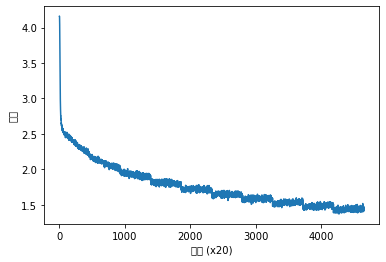

In [23]:
import sys
sys.path.append('..')
import numpy as np
from common import config

# GPU에서 실행
config.GPU = False
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from cbow import CBOW
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)
    
# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

<h3> CBOW 모델 평가 </h3>

In [25]:
import sys 
sys.path.append('..')
from common.util import most_similar
import pickle

pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']
    
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 i: 0.748046875
 we: 0.74755859375
 they: 0.62353515625
 your: 0.61279296875
 anybody: 0.57666015625

[query] year
 month: 0.84912109375
 week: 0.77294921875
 spring: 0.7548828125
 summer: 0.7431640625
 decade: 0.693359375

[query] car
 luxury: 0.6513671875
 auto: 0.64013671875
 truck: 0.62939453125
 window: 0.59228515625
 cars: 0.55810546875

[query] toyota
 nec: 0.66455078125
 nissan: 0.64111328125
 tires: 0.62158203125
 cars: 0.6181640625
 seita: 0.61376953125


In [27]:
from eval import analogy
analogy('king', 'man', 'queen',word_to_id, id_to_word, word_vecs)


[query] you
 i: 0.748046875
 we: 0.74755859375
 they: 0.62353515625
 your: 0.61279296875
 anybody: 0.57666015625

[query] year
 month: 0.84912109375
 week: 0.77294921875
 spring: 0.7548828125
 summer: 0.7431640625
 decade: 0.693359375

[query] car
 luxury: 0.6513671875
 auto: 0.64013671875
 truck: 0.62939453125
 window: 0.59228515625
 cars: 0.55810546875

[query] toyota
 nec: 0.66455078125
 nissan: 0.64111328125
 tires: 0.62158203125
 cars: 0.6181640625
 seita: 0.61376953125
--------------------------------------------------

[analogy] king:man = queen:?
 a.m: 5.69921875
 woman: 5.32421875
 naczelnik: 5.18359375
 answers: 4.796875
 rothschilds: 4.765625

[analogy] take:took = go:?
 eurodollars: 5.234375
 're: 4.71875
 was: 4.53515625
 were: 4.51171875
 came: 4.44921875

[analogy] car:cars = child:?
 a.m: 6.87890625
 rape: 5.2109375
 daffynition: 5.09375
 children: 4.953125
 adults: 4.82421875

[analogy] good:better = bad:?
 more: 5.81640625
 rather: 5.76953125
 less: 5.1796875
 greate

In [28]:
analogy('take', 'took', 'go', word_to_id, id_to_word, word_vecs)


[analogy] take:took = go:?
 eurodollars: 5.234375
 're: 4.71875
 was: 4.53515625
 were: 4.51171875
 came: 4.44921875


In [29]:
analogy('car', 'cars', 'child', word_to_id, id_to_word, word_vecs)


[analogy] car:cars = child:?
 a.m: 6.87890625
 rape: 5.2109375
 daffynition: 5.09375
 children: 4.953125
 adults: 4.82421875


In [30]:
analogy('good', 'better', 'bad', word_to_id, id_to_word, word_vecs)


[analogy] good:better = bad:?
 more: 5.81640625
 rather: 5.76953125
 less: 5.1796875
 greater: 4.5078125
 fewer: 3.8046875
